In [1]:
from transformers import AutoModel
from transformers import BertTokenizer, BertForMaskedLM
from torch.nn import functional as F
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForQuestionAnswering
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import json
import numpy as np
from collections import Counter
import pickle
from tqdm import tqdm
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig ,DistilBertTokenizerFast, DistilBertForQuestionAnswering
from transformers import AutoModel

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# More Data Processing

In [2]:
samples = pd.read_parquet('processed_data/relations_qa.parquet')
pos_samples = samples[samples.answerability == 1]
neg_samples = samples[samples.answerability == 0]

In [3]:
pos_samples.head()

,note_id,note_question_id,sub_context,question,answerability,token_start,token_end,char_start,char_end
4,0329,0,"[2014-01-20, 10:46, PM, BLOOD, Glucose, -, 114...","[Has, the, patient, had, any, rll, pneumonia, ...",1,51,80,262,408
7,0329,1,"[However, ,, when, asked, if, she, thinks, he,...","[Has, the, patient, had, any, mild, background...",1,71,79,377,426
17,0329,2,"[His, family, was, notified, that, he, was, do...","[Has, the, patient, had, any, early, sepsis, a...",1,65,75,334,386
20,0329,3,"[Physical, Exam, :, Vitals, :, T, 102.8, HR, 1...","[Has, the, patient, had, any, accessory, muscl...",1,18,42,79,212
25,0329,4,"[However, ,, when, asked, if, she, thinks, he,...","[When, was, the, patient, evaluated, for, chf,...",1,91,96,465,485


In [4]:
# pos_samples = resample(pos_samples, replace=False, n_samples=100, random_state=0) 
print('# pos', len(pos_samples))
print('# neg', len(neg_samples))
neg_samples = resample(neg_samples, replace=False, n_samples=len(pos_samples), random_state=0) 
print('# neg', len(neg_samples))

# pos 66584
# neg 467926
# neg 66584


In [5]:
samples = pd.concat([pos_samples, neg_samples], axis=0)

X = samples[['sub_context', 'question']]
X['question'] = X['question'].apply(lambda x: ' '.join(x))
X['sub_context'] = X['sub_context'].apply(lambda x: ' '.join(x))
y = samples[['answerability', 'token_start', 'token_end', 'char_start', 'char_end']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=np.asarray(y['answerability']))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  random_state=0,
                                                  stratify=np.asarray(y_train['answerability']))
    
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(79900, 2) (79900, 5)
(26634, 2) (26634, 5)
(26634, 2) (26634, 5)


C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Tokenizer + Embedding

In [6]:
tokenizer_bio = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

In [7]:
def tokenize_qa(X, y, filename=None):
    encodings = tokenizer_bio.batch_encode_plus(
      list(X.values), 
      return_tensors='pt',
      add_special_tokens = True,
      return_token_type_ids=True,
      padding='max_length',
      max_length=512,
      return_attention_mask = True,
      truncation='longest_first', 
      return_offsets_mapping=False
    )
    
    embed_token_start = []
    embed_token_end = []
    
    for i in range(len(X)):
   
        # Start position, find closest left direction
        start = encodings.char_to_token(i, y.char_start.iloc[i])
        j=0
        while start is None and j < 1000:
            j+=1
            start = encodings.char_to_token(i, max(0, y.char_start.iloc[i]-j))
        j=0
        while start is None and j < 1000:
            j+=1
            start = encodings.char_to_token(i, max(0, y.char_start.iloc[i]+j))
        # 0 index
        embed_token_start.append(start-1)
        
        
        # End position, find closest right direction then left direction
        end = encodings.char_to_token(i, max(0, y.char_end.iloc[i]-1))
        j=0
        while end is None and j < 1000:
            j+=1
            end = encodings.char_to_token(i, max(0, y.char_end.iloc[i]+j-1))
        j=0
        while end is None and j < 1000:
            j+=1
            end = encodings.char_to_token(i, max(0, y.char_end.iloc[i]-j-1))
        # 0 index
        embed_token_end.append(end-1)


    encodings['start_positions'] = torch.tensor(embed_token_start)
    encodings['end_positions'] = torch.tensor(embed_token_end)
    
    if filename:
        with open(f'processed_data/{filename}.pickle', 'wb') as f:
            pickle.dump(encodings, f)
    return encodings

In [8]:
train_encodings = tokenize_qa(X_train, y_train, filename='relations_qa_bio_train')
val_encodings = tokenize_qa(X_val, y_val, filename='relations_qa_bio_val')
test_encodings = tokenize_qa(X_test, y_test, filename='relations_qa_bio_test')

In [12]:
pd.Series(train_encodings['end_positions']).min()

0

# Training

In [2]:
class ermQA(torch.utils.data.Dataset):
    def __init__(self, filename):
        with open(f"processed_data/{filename}.pickle", "rb") as f:
            self.encodings = pickle.load(f)

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [3]:
model = AutoModelForQuestionAnswering.from_pretrained("dmis-lab/biobert-v1.1")
metadata = dict()
# for param in model.distilbert.parameters():
#     param.requires_grad = False
# model = torch.load('models/bioBERT/m_1_uf_e_6_vl_0.7865.model')
# with open('models/bioBERT/m_1_uf_e_6_vl_0.7865_metadata.pickle', 'rb') as f:
#     metadata = pickle.load(f)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
TRAIN_BATCH_SIZE = 6
train_dataset = ermQA('relations_qa_bio_train')
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)


TEST_BATCH_SIZE = 6
val_dataset = ermQA('relations_qa_bio_val')
val_loader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

In [5]:
torch.cuda.empty_cache()

NUM_EPOCHS = 10

model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)
loss_func = nn.CrossEntropyLoss()

if metadata == {}:
    START_EPOCH = 0
    train_loss = []
    val_loss = []
else:
    START_EPOCH = metadata['epoch'] + 1
    train_loss = metadata['train_loss']
    val_loss = metadata['valid_loss']


for epoch in range(START_EPOCH, START_EPOCH+NUM_EPOCHS):
    batch_loss = []
    
    # Train
    model.train()
    for batch in tqdm(train_loader):
        torch.cuda.empty_cache()

        input_ids = torch.tensor(batch['input_ids']).to(device)
        token_type_ids = torch.tensor(batch['token_type_ids']).to(device)
        attention_mask = torch.tensor(batch['attention_mask']).to(device)
        start_positions = torch.tensor(batch['start_positions']).to(device)
        end_positions = torch.tensor(batch['end_positions']).to(device)
        
        outputs = model(input_ids = input_ids, 
                        token_type_ids = token_type_ids, 
                        attention_mask = attention_mask
                       )  
        loss = loss_func(outputs['start_logits'], start_positions) + loss_func(outputs['end_logits'], end_positions)
        
        batch_loss.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step() 
    train_loss.append(np.mean(batch_loss))

        
    # Validation
    model.eval()
    batch_loss = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = torch.tensor(batch['input_ids']).to(device)
            token_type_ids = torch.tensor(batch['token_type_ids']).to(device)
            attention_mask = torch.tensor(batch['attention_mask']).to(device)
            start_positions = torch.tensor(batch['start_positions']).to(device)
            end_positions = torch.tensor(batch['end_positions']).to(device)
            outputs = model(input_ids = input_ids, 
                            token_type_ids = token_type_ids, 
                            attention_mask = attention_mask
                           )  
            loss = loss_func(outputs['start_logits'], start_positions) + loss_func(outputs['end_logits'], end_positions)
            batch_loss.append(loss.item())
    val_loss.append(np.mean(batch_loss))
    
    
    print(f'Epoch: {epoch}, train_loss: {train_loss[-1]}, val_loss: {val_loss[-1]}')
    
    model_name = f'models/bioBERT/m_1_uf_e_{len(val_loss)}_vl_{round(val_loss[-1], 4)}'
    metadata = {
        'epoch': epoch,
        'train_loss': train_loss,
        'valid_loss': val_loss
    }
    
    
    # Early Stopping
    if len(val_loss) > 3:
        if val_loss[-1] > val_loss[-2] > val_loss[-3]:
            torch.save(model, f'{model_name}.model')
            
            with open(f'{model_name}_metadata.pickle', 'wb') as f:
                pickle.dump(metadata, f)
            break
            
    # Check point
#     if len(val_loss) % 4 == 0 or NUM_EPOCHS == epoch+1:
    torch.save(model, f'{model_name}.model ')
    with open(f'{model_name}_metadata.pickle', 'wb') as f:
        pickle.dump(metadata, f)
           

  0%|          | 0/13317 [00:00<?, ?it/s]C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, i

Epoch: 0, train_loss: 0.7206070639414297, val_loss: 0.4803323878521256


100%|██████████| 4439/4439 [14:03<00:00,  5.26it/s]


Epoch: 1, train_loss: 0.46262662184167275, val_loss: 0.45042239221997304


100%|██████████| 4439/4439 [13:26<00:00,  5.51it/s]


Epoch: 2, train_loss: 4.747472540038395, val_loss: 12.476650028783046


100%|██████████| 4439/4439 [13:28<00:00,  5.49it/s]


Epoch: 3, train_loss: 12.479288038248198, val_loss: 12.476649371372952


  5%|▍         | 661/13317 [06:46<2:09:48,  1.62it/s]


KeyboardInterrupt: 

# Metrics

In [3]:
def compute_exact_match(prediction, truth):
    exact_match = 0
    for pred, tru in zip(prediction, truth):
        if pred == tru:
            exact_match += 1
    return exact_match / len(prediction)


def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))


def compute_tav_fast(start_logits, end_logits):
    start_probs, end_probs = (torch.softmax(start_logits, dim=0), torch.softmax(end_logits, dim=0))
    n = len(start_logits)
    s_null = start_probs[0] + end_probs[0]
    s_has = 0
    best_span = (0, 0)
    high_start_idx = 1
  
    for i in range(1, n):
        if start_probs[i] > start_probs[high_start_idx]:
            high_start_idx = i
        if start_probs[high_start_idx] + end_probs[i] > s_has:
            s_has = start_probs[high_start_idx] + end_probs[i]
            best_span = (high_start_idx, i)
            
    s_diff = s_null - s_has
    return s_diff.item(), best_span

def compute_f1(prediction, truth, input_id_list):
    
    f1_scores = []
    
    for i, (pred, gold) in enumerate(zip(prediction, truth)):
        
        if pred == gold:
            f1_scores.append(1)
            
        else:
            pred_tokens = input_id_list[i-1][pred[0]: pred[1]+1]
            gold_tokens = input_id_list[i-1][gold[0]: gold[1]+1]

            total_overlap = len(set(pred_tokens).intersection(set(gold_tokens)))
            total_tru = len(gold_tokens)
            total_pred = len(pred_tokens)

            if len(pred_tokens) == 0 or len(gold_tokens) == 0:
                f1_scores.append(int(pred_tokens == gold_tokens))
            elif total_overlap == 0:
                f1_scores.append(0)
            else:
                prec = total_overlap / total_pred
                rec = total_overlap / total_tru
                f1_scores.append(2 * (prec * rec) / (prec + rec))
    
    return np.mean(f1_scores)

In [13]:
def generate_predictions(model, data_loader, split):
    truths = []
    
    # Greedy
    spans_greedy = []
    
    # TAV
    s_diffs = []
    spans_tav = []
    
    input_id_list = []
    
    model.eval()
    for batch in tqdm(data_loader):
        
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # Truth Span
            for i, j, k in zip(batch['start_positions'], batch['end_positions'], batch['input_ids']):
                truths.append((i.item(), j.item()))
                input_id_list.append(k.tolist())
        
            
            # Predictions
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            
            # Greedy
            for i, j in zip(torch.argmax(outputs['start_logits'], dim=1), torch.argmax(outputs['end_logits'], dim=1)):
                spans_greedy.append((i.item(), j.item()))
            
            # TAV
            for i, j in zip(outputs['start_logits'], outputs['end_logits']):
                s_diff, span = compute_tav_fast(i, j)
                s_diffs.append(s_diff)
                spans_tav.append(span)
    
    predictions_metadata = {
        'truth': truths,
        'spans_greedy': spans_greedy,
        's_diffs': s_diffs,
        'spans_tav': spans_tav,
        'input_id_list': input_id_list
    }
    with open(f'predictions/bioBERT/relations_{split}.pickle', 'wb') as f:
        pickle.dump(predictions_metadata, f)
            
    return predictions_metadata


def evaluate_predictions(predictions_metadata, tav=False, threshold=-0.98, print_info=False):
    if not tav:
        spans_pred = predictions_metadata['spans_greedy']
    else:
        spans_pred = []
        for s_diff, span_tav in zip(predictions_metadata['s_diffs'], predictions_metadata['spans_tav']):
            if s_diff < threshold:
                spans_pred.append(span_tav)
            else:
                spans_pred.append((0, 0))
                
    em = compute_exact_match(spans_pred, predictions_metadata['truth'])
    f1 = compute_f1(spans_pred,  predictions_metadata['truth'], predictions_metadata['input_id_list'])
    
    if print_info:
        print(f'EM: {round(em*100, 1)}, F1: {round(f1*100, 1)}')
        
    return em, f1

In [4]:
TEST_BATCH_SIZE = 64
test_dataset = ermQA('relations_qa_bio_test')
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)


train_dataset = ermQA('relations_qa_bio_train')
train_loader = DataLoader(train_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

model = torch.load('models/bioBERT/r_1_uf_e_2_vl_0.4504.model')

In [14]:
test_predictions_metadata = generate_predictions(model, test_loader, 'test')
# with open('predictions/bioBERT/medication_test.pickle', 'rb') as f:
#     test_predictions_metadata = pickle.load(f)

  0%|          | 0/417 [00:00<?, ?it/s]C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
100%|██████████| 417/417 [38:38<00:00,  5.56s/it]


In [15]:
em, f1 = evaluate_predictions(test_predictions_metadata, tav=False, print_info=True)

EM: 46.4, F1: 49.3


In [23]:
em, f1 = evaluate_predictions(test_predictions_metadata, tav=True, threshold=.59, print_info=True)

EM: 51.2, F1: 53.1


In [17]:
train_predictions_metadata = generate_predictions(model, train_loader, 'train')

  0%|          | 0/1249 [00:00<?, ?it/s]C:\Users\lcwon\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
100%|██████████| 1249/1249 [1:55:40<00:00,  5.56s/it]


In [18]:
em, f1 = evaluate_predictions(train_predictions_metadata, tav=False, print_info=True)

EM: 48.1, F1: 50.9


In [21]:
em_list = []
thresholds = []
for threshold in np.arange(-1, 1, .01):
    em, f1 = evaluate_predictions(train_predictions_metadata, tav=True, threshold=threshold, print_info=False)
    em_list.append(em)
    thresholds.append(threshold)

-0.5899999999999996
EM: 59.6, F1: 60.0


(0.5962202753441802, 0.6002993313730656)

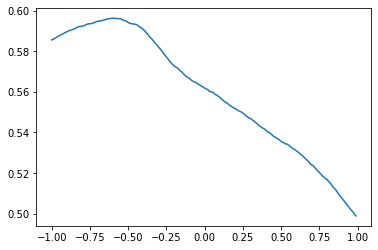

In [22]:
sns.lineplot(x=thresholds, y=em_list)
max_index = em_list.index(max(em_list))
threshold = thresholds[max_index]
print(threshold)
evaluate_predictions(train_predictions_metadata, tav=True, threshold=threshold, print_info=True)